##### Import necessery libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport
from xgboost import XGBRegressor

from sklearn.metrics import r2_score,mean_absolute_error


import warnings
warnings.filterwarnings('ignore')

##### Loading the dataset

In [3]:
df = pd.read_csv('insurance.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [6]:
df.describe(exclude=np.number).T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [7]:
# correlated columns with respect to target column
df[df.describe().columns].corr()['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

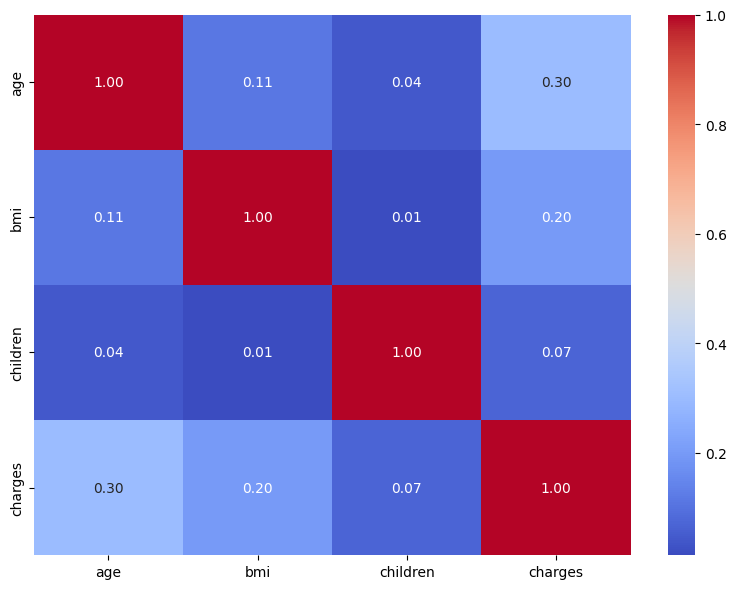

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df[df.describe().columns].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.tight_layout()
plt.show()

##### Y-data profiling

In [9]:
profile = ProfileReport(df,title='Medical cost',explorative=True)
profile.to_file('cost.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 207.03it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
X = df.drop(columns=['charges'])
y = df['charges']

In [11]:
# separating numerical and categorical columns
num_cols = X.select_dtypes(['int64','float64']).columns
cat_cols = X.select_dtypes(['object']).columns

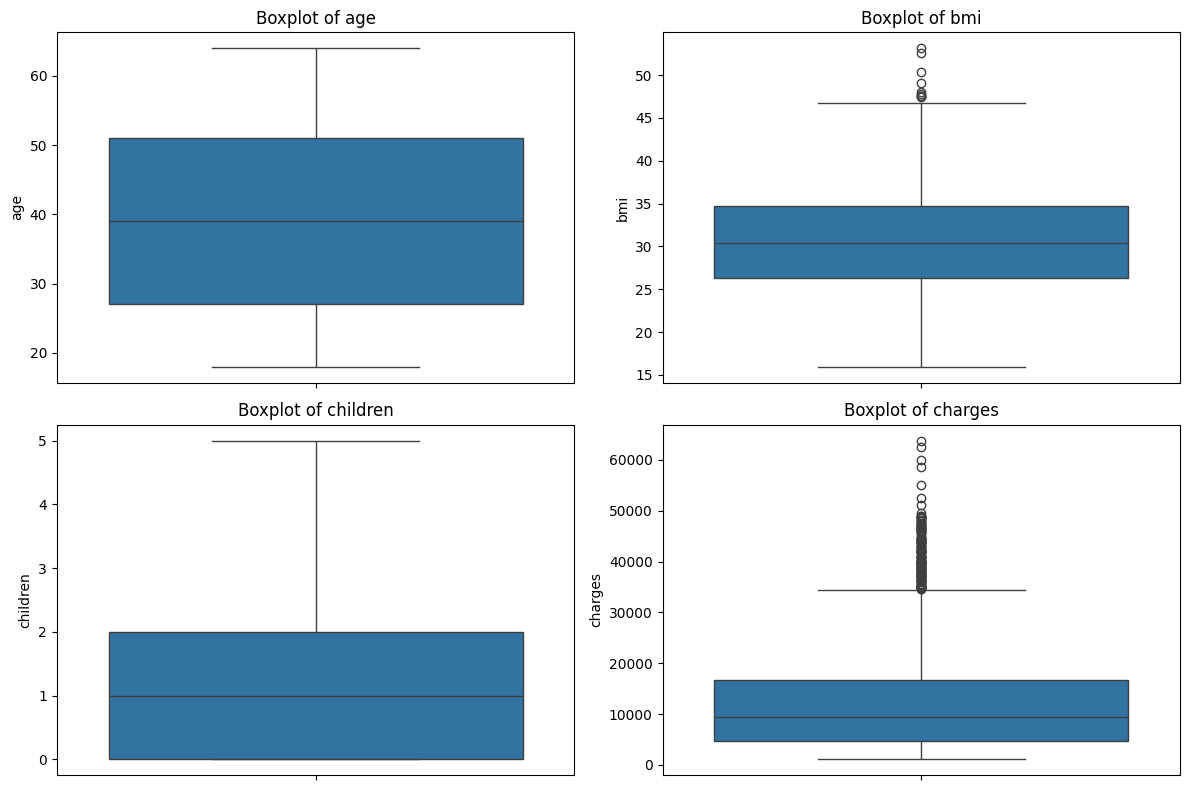

In [12]:
# figuring if there any outliers present or not
# charges column have a lot of outliers but it's our target column
# we can avoid these smaller bmi outliers
# other numerical columns are outliers free
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.describe().columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [13]:
# no nan values were found. So no need to deal with nan's
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

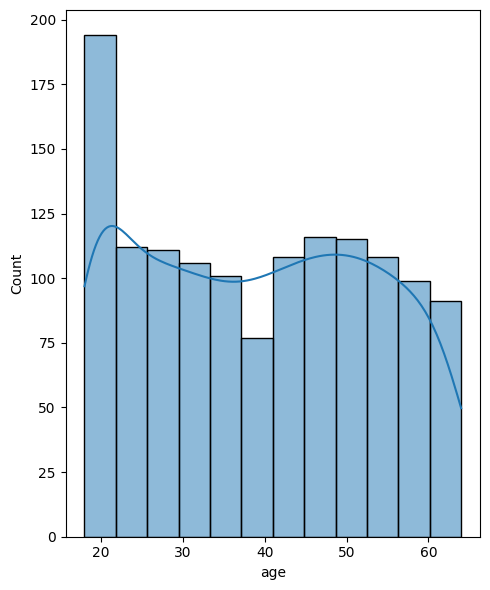

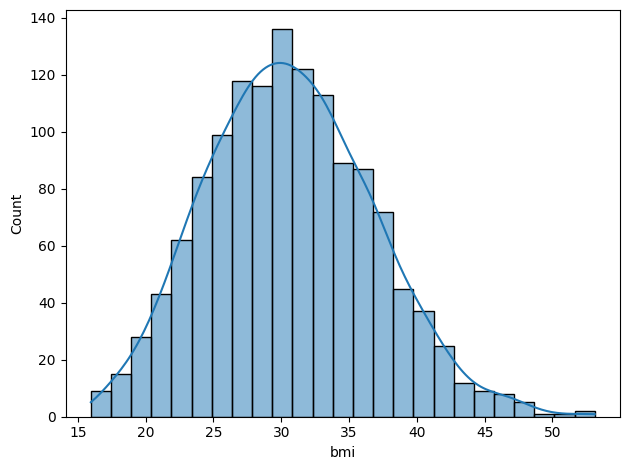

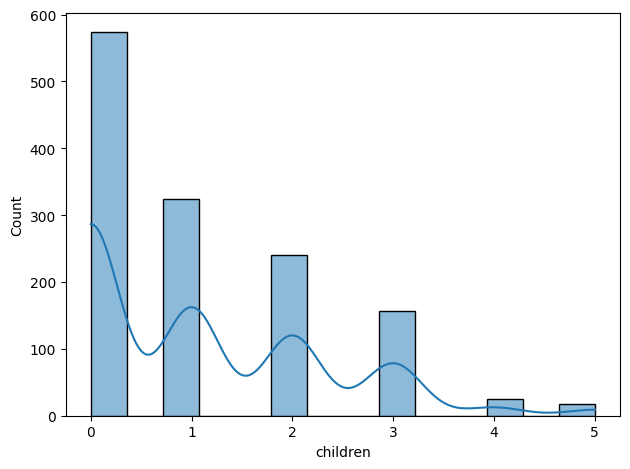

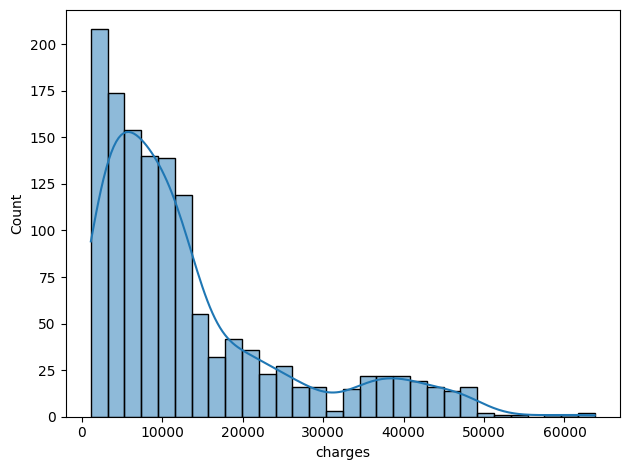

In [14]:
# getting the skewness
plt.figure(figsize=(5,6))
for i in df.describe().columns:
    sns.histplot(data=df,x=i, kde=True)
    plt.tight_layout()
    plt.show()

In [15]:
df.duplicated().sum()

np.int64(1)

In [16]:
# handling duplicates
df.drop_duplicates(inplace=True)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [18]:
# separate pipelines for both numerical and categorical features
# scaling with standard scaler 
# categorical colmuns were encoded by One hot encoder
num_pipeline = Pipeline(steps=[
    ('scaler',StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
# Merge modified categorical and numerical columns
preprocessor = ColumnTransformer(transformers=[
    ('num',num_pipeline,num_cols),
    ('cat',cat_pipeline,cat_cols)
])

In [20]:
# First trying with different models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
}


In [21]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    
    results[name] = r2
    print(f"{name}: MAE = {mean_absolute_error(y_test,preds)}")


LinearRegression: MAE = 4181.19447375365
Ridge: MAE = 4186.91307178384
RandomForest: MAE = 2525.646339172215
GradientBoosting: MAE = 2392.4707185419443
XGBoost: MAE = 2701.4922012504503


In [22]:
# r2 score for each models
results

{'LinearRegression': 0.7835929767120723,
 'Ridge': 0.7834425531348183,
 'RandomForest': 0.8634732390810892,
 'GradientBoosting': 0.8781342988109576,
 'XGBoost': 0.8499405455710048}

##### RandomizedSearchCV for GradientBoosting

In [23]:
gb_param = {
    "model__n_estimators": [200, 300, 400],
    "model__learning_rate": [0.03, 0.05, 0.07],
    "model__max_depth": [2, 3, 4],
    "model__min_samples_leaf": [5, 10, 20],
    "model__subsample": [0.7, 0.85, 1.0]
}

pipe_gb = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_search = RandomizedSearchCV(
    pipe_gb,
    gb_param,
    n_iter=30,
    scoring="r2",
    cv=10,
    n_jobs=-1,
    random_state=42
)

gb_search.fit(X_train, y_train)

print("Best GB params:")
print(gb_search.best_params_)
print("Best CV R2:", gb_search.best_score_)

Best GB params:
{'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_samples_leaf': 20, 'model__max_depth': 3, 'model__learning_rate': 0.03}
Best CV R2: 0.851476846955362


In [24]:
# cross validation using best parameters(10 fold)
pipe_gb = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        subsample=.7,
        n_estimators=200,
        learning_rate=0.03,
        max_depth=3,
        random_state=42,
        min_samples_leaf=20,
    ))
])

scores = cross_val_score(pipe_gb, X_train, y_train, cv=10, scoring="r2")

print(scores)
print("Mean:", scores.mean())


[0.85275176 0.83271933 0.92857098 0.91850563 0.86306376 0.78643863
 0.79071859 0.81593249 0.86515358 0.86091373]
Mean: 0.851476846955362


##### RandomizedSearchCV for XGBoost

In [25]:
xgb_param_grid = {
    "model__n_estimators": [300, 500, 700],
    "model__learning_rate": [0.03, 0.05, 0.07],
    "model__max_depth": [3, 4, 5, 6],
    "model__min_child_weight": [1, 3, 5, 10],
    "model__gamma": [0, 0.05, 0.1, 0.2],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__reg_alpha": [0, 0.01, 0.1],
    "model__reg_lambda": [1, 1.5, 2]
}

pipe_xgb = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

xgb_search = RandomizedSearchCV(
    pipe_xgb,
    xgb_param_grid,
    n_iter=40,
    scoring="r2",
    cv=10,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:")
print(xgb_search.best_params_)
print("Best CV R2:", xgb_search.best_score_)


Best XGB params:
{'model__subsample': 0.7, 'model__reg_lambda': 1, 'model__reg_alpha': 0, 'model__n_estimators': 300, 'model__min_child_weight': 10, 'model__max_depth': 3, 'model__learning_rate': 0.03, 'model__gamma': 0, 'model__colsample_bytree': 0.85}
Best CV R2: 0.8479049408226598


In [26]:
# cross validation using best parameters
cv_scores = cross_val_score(
    xgb_search.best_estimator_,
    X_train,
    y_train,
    cv=10,
    scoring="r2",
    n_jobs=-1
)
print(cv_scores.mean(), cv_scores.std())

0.8479049408226598 0.044845978127811686


In [27]:
best_gb = gb_search.best_estimator_
best_xgb = xgb_search.best_estimator_

gb_preds = best_gb.predict(X_test)
xgb_preds = best_xgb.predict(X_test)

print("GB Test R2:", r2_score(y_test, gb_preds))
print("GB MAE:", mean_absolute_error(y_test, gb_preds))

print("XGB Test R2:", r2_score(y_test, xgb_preds))
print("XGB MAE:", mean_absolute_error(y_test, xgb_preds))


GB Test R2: 0.87860257933407
GB MAE: 2488.986942267796
XGB Test R2: 0.8819267073825203
XGB MAE: 2391.074957476446


In [28]:
#XGBoost getting the highest r2 and good mae in both randomized search cv and cross validation. So we select
# XGBoost as our final model.
xgb = XGBRegressor(subsample=.7,reg_lambda=1,reg_alpha=9,n_estimators=300,min_child_weight=10,max_depth=3,
learning_rate=.03,gamma=0,colsample_bytree=.85
)
final_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
    subsample=.7,reg_lambda=1,
    reg_alpha=9,n_estimators=300,
    min_child_weight=10,max_depth=3,
    learning_rate=.03,gamma=0,
    colsample_bytree=.85
    ))
])
final_pipe.fit(X_train,y_train)
y_pred = final_pipe.predict(X_test)
r2_score(y_test,y_pred)

0.8816553748015594

##### Saving the model

In [29]:
file_name = 'medical_model.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(final_pipe,file)